## Imports needed for qiskit part

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_qsphere
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *
import qiskit.quantum_info as qi

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output


## imports needed for kaggle solution https://www.kaggle.com/nayansakhiya/heart-fail-analysis-and-quick-prediction

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

## General imports

In [2]:
import warnings
warnings.simplefilter('ignore')

import random
import time

random.seed(69069)
np.random.seed(69069)

## Classical Solution

In [3]:
heart_data = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')

# only the features used in the notebook
Features = ['time','ejection_fraction','serum_creatinine']
x = heart_data[Features]
y = heart_data["DEATH_EVENT"]
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=2)

In [10]:
heart_data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [8]:
#train the gradient boosting classifier
gradientboost_clf = GradientBoostingClassifier(max_depth=2, random_state=1)
gradientboost_clf.fit(x_train,y_train)
gradientboost_pred = gradientboost_clf.predict(x_test)
gradientboost_acc = accuracy_score(y_test, gradientboost_pred)
print("Accuracy of Gradient Boosting is : ", "{:.2f}%".format(100* gradientboost_acc))


Accuracy of Gradient Boosting is :  93.33%


In [9]:
# CatBoostClassifier
cat_clf = CatBoostClassifier()
cat_clf.fit(x_train,y_train)
cat_clf_pred = cat_clf.predict(x_test)
cat_clf_acc = accuracy_score(y_test, cat_clf_pred)
print("Accuracy of Gradient Boosting is : ", "{:.2f}%".format(100* cat_clf_acc))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.005591
0:	learn: 0.6898089	total: 50.7ms	remaining: 50.6s
1:	learn: 0.6853691	total: 52ms	remaining: 25.9s
2:	learn: 0.6814224	total: 53ms	remaining: 17.6s
3:	learn: 0.6763787	total: 53.9ms	remaining: 13.4s
4:	learn: 0.6732323	total: 54.8ms	remaining: 10.9s
5:	learn: 0.6693704	total: 55.5ms	remaining: 9.19s
6:	learn: 0.6649135	total: 56.4ms	remaining: 7.99s
7:	learn: 0.6609337	total: 57.3ms	remaining: 7.11s
8:	learn: 0.6571249	total: 58.3ms	remaining: 6.42s
9:	learn: 0.6521269	total: 59.7ms	remaining: 5.91s
10:	learn: 0.6485155	total: 60.4ms	remaining: 5.43s
11:	learn: 0.6440567	total: 61.3ms	remaining: 5.05s
12:	learn: 0.6409554	total: 62.1ms	remaining: 4.71s
13:	learn: 0.6370791	total: 63ms	remaining: 4.44s
14:	learn: 0.6329117	total: 63.8ms	remaining: 4.19s
15:	learn: 0.6288988	total: 64.3ms	remaining: 3.96s
16:	learn: 0.6246823	total: 65ms	remaining: 3.76s
17:	learn: 0.6210250	total: 66.7ms	remaining: 3.64s
18:	learn: 0.6177116	total: 69.1ms	remaining: 3.57s


## Quantum Solution

In [4]:
#More functions needed for training
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

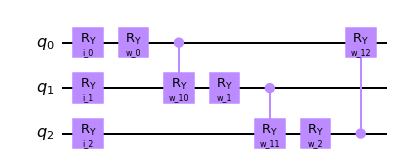

In [7]:
#Using our known, reliable circuit, we will do a comparison
def fit_and_score(circuit_classifier, x_train, y_train, x_test, y_test):

    plt.rcParams["figure.figsize"] = (12, 6)

    # fit classifier to data
    circuit_classifier.fit(x_train, y_train)
    score_train =  circuit_classifier.score(x_train, y_train)
    score_test =  circuit_classifier.score(x_test, y_test)
    print("Mean Accuracy traingin: " + str(score_train))
    print("Mean Accuracy testing: " + str(score_test))

    # return to default figsize
    plt.rcParams["figure.figsize"] = (6, 4)

    # score classifier
    score =  circuit_classifier.score(np.concatenate((x_train, x_test)), np.concatenate((y_train, y_test)))
    print('Mean Accuracy overall: ' + str(score))

n = len(Features)
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
def parity(x):
    return '{:b}'.format(x).count('1') % 2

feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

for i in range(n):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%n)

qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))
                                    


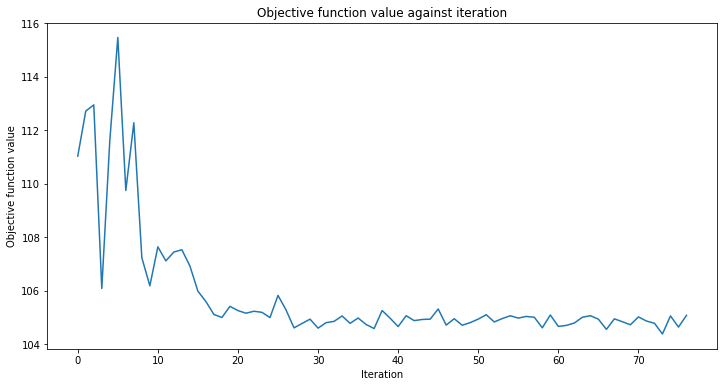

Mean Accuracy traingin: 0.5983263598326359
Mean Accuracy testing: 0.6
Mean Accuracy overall: 0.5852842809364549
Non-normalized data


In [34]:

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
fit_and_score(circuit_classifier, x_train.values, y_train.values, x_test.values, y_test.values)
print('Non-normalized data')

In [16]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    return MinMaxScaler().fit_transform(data) * 2 - 1

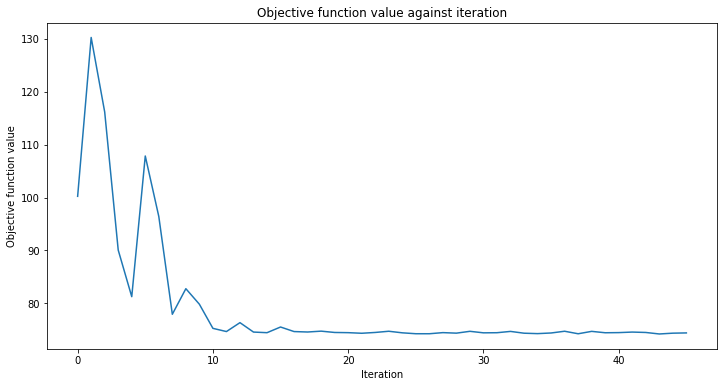

Mean Accuracy traingin: 0.6778242677824268
Mean Accuracy testing: 0.7
Mean Accuracy overall: 0.68561872909699
Normalized data


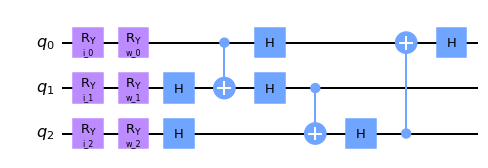

In [20]:


# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values)
print('Normalized data')        
display(qc.decompose().draw('mpl'))

In [21]:
def pifi_data(data):
    return MinMaxScaler().fit_transform(data) * 2*np.pi - np.pi


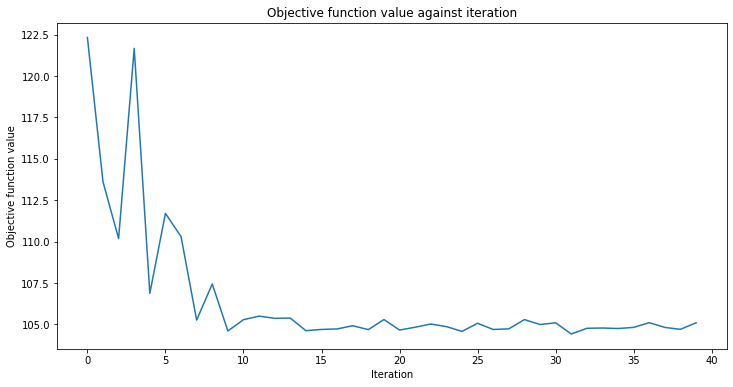

Mean Accuracy traingin: 0.5983263598326359
Mean Accuracy testing: 0.5833333333333334
Mean Accuracy overall: 0.5919732441471572
Normalized * pi data


In [22]:

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
fit_and_score(circuit_classifier, pifi_data(x_train.values), y_train.values, 
    pifi_data(x_test.values), y_test.values)
print('Normalized * pi data')   

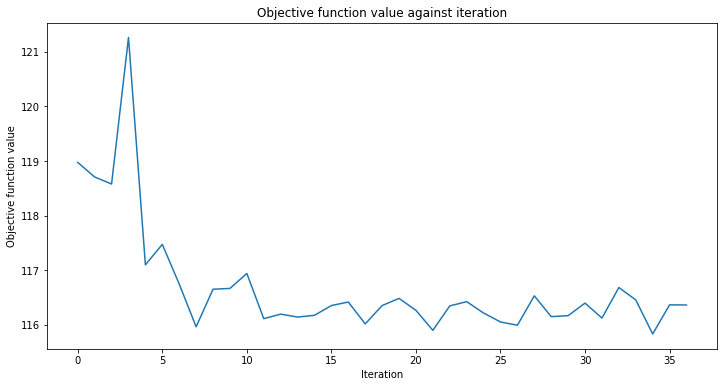

Mean Accuracy traingin: 0.5774058577405857
Mean Accuracy testing: 0.48333333333333334
Mean Accuracy overall: 0.5250836120401338
Non-normalized data


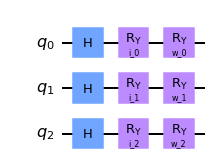

In [23]:
feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

for i in range(n):
    feature_map.h(i)
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)

qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))


circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

                                        

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
fit_and_score(circuit_classifier, x_train.values, y_train.values, x_test.values, y_test.values)
print('Non-normalized data')    
display(qc.decompose().draw('mpl'))

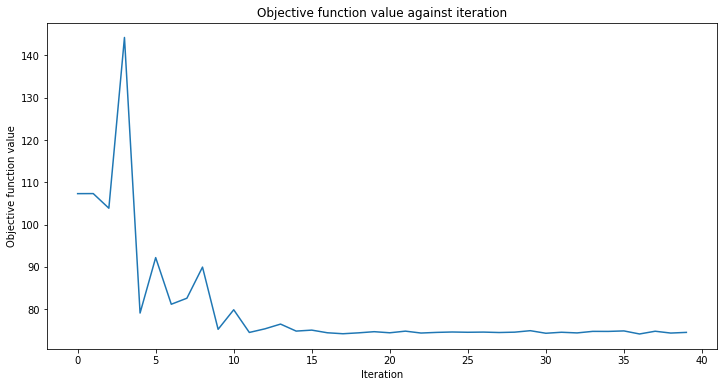

Mean Accuracy traingin: 0.6778242677824268
Mean Accuracy testing: 0.7
Mean Accuracy overall: 0.6822742474916388
Normalized data


In [24]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values)
print('Normalized data')        

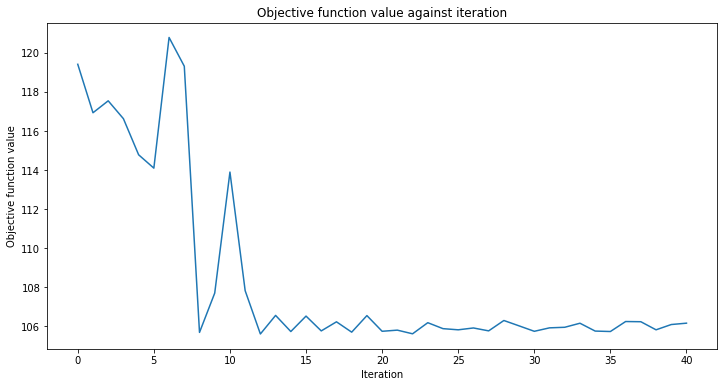

Mean Accuracy traingin: 0.606694560669456
Mean Accuracy testing: 0.5833333333333334
Mean Accuracy overall: 0.5819397993311036
Normalized * pi data


In [25]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
fit_and_score(circuit_classifier, pifi_data(x_train.values), y_train.values, 
    pifi_data(x_test.values), y_test.values)
print('Normalized * pi data')   

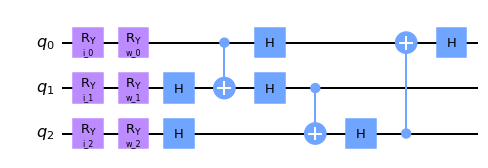

In [26]:
feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

for i in range(n):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)

qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))
qc.cz(0,1)
qc.cz(1,2)
qc.cz(2,0)

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

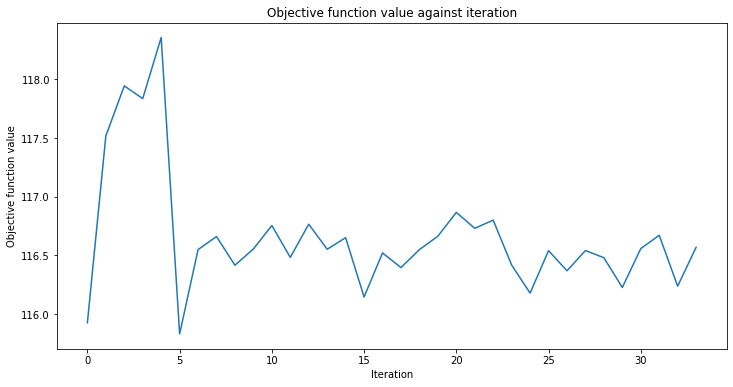

Mean Accuracy traingin: 0.5648535564853556
Mean Accuracy testing: 0.4166666666666667
Mean Accuracy overall: 0.5484949832775919
Non-normalized data


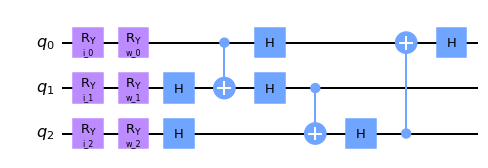

In [27]:

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
fit_and_score(circuit_classifier, x_train.values, y_train.values, x_test.values, y_test.values)
print('Non-normalized data')    

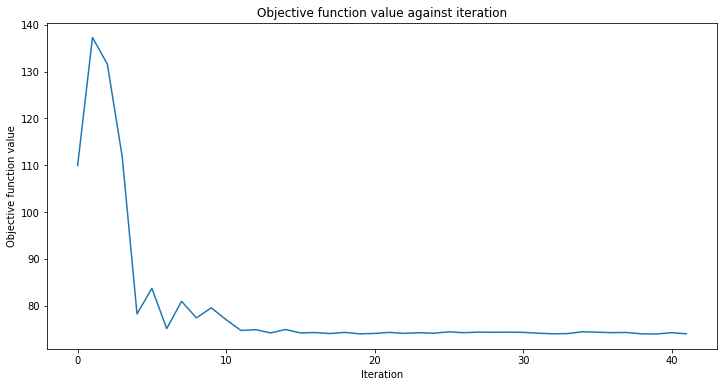

Mean Accuracy traingin: 0.6778242677824268
Mean Accuracy testing: 0.7
Mean Accuracy overall: 0.6822742474916388
Normalized data


In [28]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values)
print('Normalized data')   

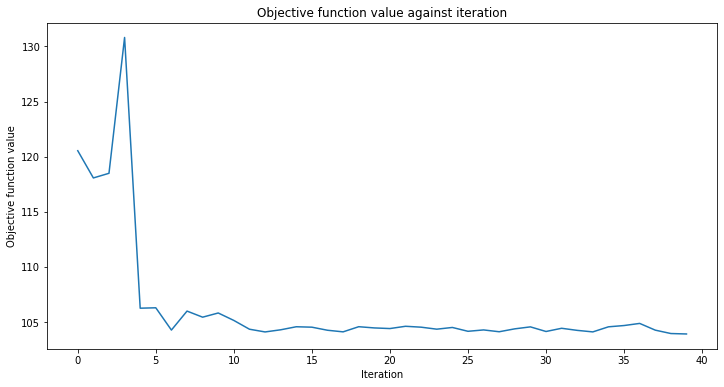

Mean Accuracy traingin: 0.5857740585774058
Mean Accuracy testing: 0.5833333333333334
Mean Accuracy overall: 0.5886287625418061
Normalized * pi data


In [29]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
fit_and_score(circuit_classifier, pifi_data(x_train.values), y_train.values, 
    pifi_data(x_test.values), y_test.values)
print('Normalized * pi data')   

In [38]:
feature_map = QuantumCircuit(n)
ansatz = QuantumCircuit(n)

for i in range(n):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)

qc = QuantumCircuit(n)
qc.append(feature_map, range(n))
qc.append(ansatz, range(n))


for i in range(n):
    qc.cry(Parameter('w_' + str(10+i)), i, (i+1)%n)

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)



In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
fit_and_score(circuit_classifier, normalize_data(x_train.values), y_train.values, 
    normalize_data(x_test.values), y_test.values)
print('Normalized data')   

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
fit_and_score(circuit_classifier, pifi_data(x_train.values), y_train.values, 
    pifi_data(x_test.values), y_test.values)
print('Normalized * pi data')  